# Generational changes in religious affiliaton, beliefs, and attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1', 6)

from collections import Counter
from statsmodels.discrete.discrete_model import MNLogit

#import warnings
#warnings.filterwarnings("error")

In [2]:
from empiricaldist import Cdf

In [3]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()


## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from  https://gssdataexplorer.norc.org/extracts/21438/download

In [191]:
gss = utils.ReadGss('gss_college_religion')
print(gss.shape)
gss.head()

(64814, 19)


,year,coninc,colath,spkath,rincome,income,race,sex,god,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,sei
0,1972,25926.0,4,1,0,0,1,2,0,0,0,1949,23,0.4446,0,3,16,1,-1.0
1,1972,33333.0,5,1,0,0,1,1,0,0,0,1902,70,0.8893,0,2,10,2,-1.0
2,1972,33333.0,5,1,0,0,1,2,0,0,0,1924,48,0.8893,0,1,12,3,-1.0
3,1972,41667.0,5,1,0,0,1,2,0,0,0,1945,27,0.8893,0,5,17,4,-1.0
4,1972,69444.0,4,1,0,0,1,2,0,0,0,1911,61,0.8893,0,1,12,5,-1.0


In [190]:
columns = ['year', 'coninc', 'colath', 'spkath', 'rincome', 'income', 'race',
       'sex', 'god', 'conclerg', 'bible', 'cohort', 'age', 'wtssall', 'ballot',
       'relig', 'educ', 'id_', 'sei']

Index(['year', 'coninc', 'colath', 'spkath', 'rincome', 'income', 'race',
       'sex', 'god', 'conclerg', 'bible', 'cohort', 'age', 'wtssall', 'ballot',
       'relig', 'educ', 'id_', 'sei', 'age_group', 'cohort5', 'cohort10',
       'prot', 'cath', 'none', 'other', 'relig4', 'nobelief', 'belief',
       'strongbelief', 'belief3', 'confident', 'someconf', 'noconf', 'literal',
       'inspired', 'legends', 'ones', 'c', 'a'],
      dtype='object')

Question 1: Interpretation of the bible https://gssdataexplorer.norc.org/projects/29853/variables/1076/vshow

In [6]:
gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)
sum(gss.bible.isnull())

29495

In [7]:
utils.values(gss, 'bible')

1.0    11891
2.0    17005
3.0     6423
Name: bible, dtype: int64

Question 2: Confidence in the people running religious institutions https://gssdataexplorer.norc.org/projects/29853/variables/450/vshow

In [8]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.conclerg.isnull())

22389

In [9]:
utils.values(gss, 'conclerg')

1.0    11681
2.0    21692
3.0     9052
Name: conclerg, dtype: int64

Question 3: Belief in God https://gssdataexplorer.norc.org/projects/29853/variables/1076/vshow

In [10]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40160

In [11]:
utils.values(gss, 'god')

1.0      782
2.0     1260
3.0     2584
4.0      988
5.0     4072
6.0    14968
Name: god, dtype: int64

Question 4: Religious preference https://gssdataexplorer.norc.org/projects/29853/variables/287/vshow

In [12]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

289

In [13]:
utils.values(gss, 'relig')

1.0     37117
2.0     15674
3.0      1285
4.0      7797
5.0      1086
6.0       198
7.0       100
8.0        39
9.0       153
10.0      118
11.0      791
12.0       31
13.0      136
Name: relig, dtype: int64

Age https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [14]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

228

Year of birth https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [15]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

228

Drop records if age or cohort is missing.

In [16]:
gss.dropna(subset=['age', 'cohort'], inplace=True)
gss.shape

(64585, 19)

Here's the distribution of ages.

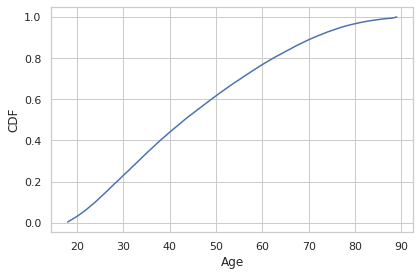

In [18]:
Cdf.from_seq(gss.age).plot()
decorate(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [19]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

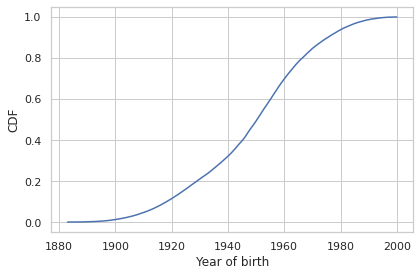

In [20]:
Cdf.from_seq(gss.cohort).plot()
decorate(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [21]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=1) + 2.5

In [22]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.relig.count()
counts

cohort5
1883.5      12
1888.5      75
1893.5     208
1898.5     502
1903.5     872
1908.5    1329
1913.5    1877
1918.5    2482
1923.5    2971
1928.5    3203
1933.5    3289
1938.5    3843
1943.5    4831
1948.5    6232
1953.5    6661
1958.5    6505
1963.5    5359
1968.5    4202
1973.5    3200
1978.5    2659
1983.5    1954
1988.5    1210
1993.5     641
1998.5     201
Name: relig, dtype: int64

In [23]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

In [24]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.relig.count()
counts

cohort10
1880.0       60
1890.0      607
1900.0     2046
1910.0     4126
1920.0     6045
1930.0     6976
1940.0    10591
1950.0    13253
1960.0     9920
1970.0     6203
1980.0     3470
1990.0      999
2000.0       22
Name: relig, dtype: int64

Here's the number of respondents in each year.

In [25]:
utils.values(gss, 'year')

1972    1608
1973    1500
1974    1478
1975    1485
1976    1493
1977    1523
1978    1525
1980    1459
1982    1845
1983    1592
1984    1467
1985    1527
1986    1463
1987    1807
1988    1477
1989    1533
1990    1372
1991    1514
1993    1601
1994    2986
1996    2898
1998    2827
2000    2809
2002    2751
2004    2803
2006    4492
2008    2013
2010    2041
2012    1969
2014    2529
2016    2857
2018    2341
Name: year, dtype: int64

## Recoding

Creating one-hots and categorical variables for the dependent variables.

In [74]:
def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
     # lumping "Christian" with Protestant
    df['prot'] = df.relig.isin([1,11]).astype(float)

    # lumping "Orthodox-Christian" with Catholic
    df['cath'] = df.relig.isin([2,10]).astype(float)
    df['none'] = (df.relig==4).astype(float)
    df['other'] = df.relig.isin([3,5,6,7,8,9,12,13]).astype(float)
    
    # recoding relig4 with just 4 categories
    df['relig4'] = df.relig.copy()
    df.relig4.replace([11], 1, inplace=True)
    df.relig4.replace([10], 2, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    varnames = ['prot', 'cath', 'none', 'other']
    
    # anywhere relig is null, the recoded variables should be, too
    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(gss)

In [75]:
sum(gss.relig.isnull())

267

In [76]:
utils.values(gss, 'relig4')

1.0    37792
2.0    15745
3.0     3008
4.0     7773
Name: relig4, dtype: int64

In [77]:
def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    # reducing the number of categories to 3
    df['nobelief'] = (df.god.isin([1, 2])).astype(float)
    df['belief'] = (df.god.isin([3, 4, 5])).astype(float)
    df['strongbelief'] = (df.god.isin([6])).astype(float)
    
    df['belief3'] = df.god.copy()
    df.belief3.replace([1, 2], 1, inplace=True)
    df.belief3.replace([3, 4, 5], 2, inplace=True)
    df.belief3.replace([6], 3, inplace=True)

    varnames = ['strongbelief', 'belief', 'nobelief', 'belief3']
    df.loc[df.god.isnull(), varnames] = np.nan
    
create_belief_vars(gss)

In [78]:
sum(gss.god.isnull())

39991

In [79]:
utils.values(gss, 'belief3')

1.0     2039
2.0     7632
3.0    14923
Name: belief3, dtype: int64

In [80]:
def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1).astype(float)
    df['someconf'] = (df.conclerg == 2).astype(float)
    df['noconf'] = (df.conclerg == 3).astype(float)

    varnames = ['confident', 'someconf', 'noconf']
    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
create_conf_vars(gss)

In [81]:
sum(gss.conclerg.isnull())

22298

In [82]:
utils.values(gss, 'conclerg')

1.0    11644
2.0    21619
3.0     9024
Name: conclerg, dtype: int64

In [83]:
def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['literal'] = (df.bible == 1).astype(float)
    df['inspired'] = (df.bible == 2).astype(float)
    df['legends'] = (df.bible == 3).astype(float)

    varnames = ['literal', 'inspired', 'legends']
    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(gss)

In [84]:
sum(gss.bible.isnull())

29359

In [85]:
utils.values(gss, 'bible')

1.0    11853
2.0    16962
3.0     6411
Name: bible, dtype: int64

In [86]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    
    # also add quadratic factors and interaction term
    #df['c2'] = df.c**2
    #df['a2'] = df.a**2
    #df['ac'] = df.a * df.c

In [87]:
center_factors(gss)

## Resample

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [88]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,coninc,colath,spkath,rincome,income,race,sex,god,conclerg,...,belief3,confident,someconf,noconf,literal,inspired,legends,ones,c,a
0,1972,33333.0,4,1,0,0,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-24.0,-17.0
1,1972,50926.0,5,1,0,0,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-58.0,17.0
2,1972,69444.0,4,1,0,0,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-24.0,-17.0
3,1972,33333.0,4,1,0,0,2,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-25.0,-16.0
4,1972,50926.0,5,1,0,0,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-42.0,1.0


### Run logistic models

One religion category at a time, as opposed to the multinomial models below.

In [89]:
formula = 'prot ~ c + a'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.665927
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                64299
Model:                          Logit   Df Residuals:                    64296
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 Aug 2022   Pseudo R-squ.:                 0.02241
Time:                        09:41:31   Log-Likelihood:                -42818.
converged:                       True   LL-Null:                       -43800.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0392      0.013      2.923      0.003       0.013       0.066
c             -0.0179      0.001    -29.368      0.000      -0.019      -0.017
a             -0.0010      0.001     -1.370      0.171      -0.002       0.000
==============================================================================
"""

In [90]:
age = [37, 47, 37, 47]
cohort = [1980, 1980, 1990, 1990]
new = pd.DataFrame(dict(age=age, cohort=cohort))
center_factors(new)

In [91]:
def model_predict(model, new):
    res = new.copy()
    res['pred'] = model.predict(new) * 100
    res['diff'] = res.pred - res.pred[0]
    return res[['cohort', 'age',  'pred', 'diff']]

In [92]:
model_predict(model, new)

,cohort,age,pred,diff
0,1980,37,44.990995,0.000000
1,1980,47,44.740323,-0.250672
2,1990,37,40.615482,-4.375512
3,1990,47,40.371298,-4.619697


In [93]:
formula = 'none ~ c + a'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.348576
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                64299
Model:                          Logit   Df Residuals:                    64296
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 Aug 2022   Pseudo R-squ.:                 0.06583
Time:                        09:41:34   Log-Likelihood:                -22413.
converged:                       True   LL-Null:                       -23993.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4808      0.018    -80.441      0.000      -1.517      -1.445
c              0.0410      0.001     42.131      0.000       0.039       0.043
a              0.0109      0.001      9.206      0.000       0.009       0.013
==============================================================================
"""

In [94]:
model_predict(model, new)

,cohort,age,pred,diff
0,1980,37,26.588719,0.000000
1,1980,47,28.779808,2.191089
2,1990,37,35.317354,8.728635
3,1990,47,37.856813,11.268094


In [95]:
formula = 'relig4 ~ c + a'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.035663
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                64299
Model:                        MNLogit   Df Residuals:                    64290
Method:                           MLE   Df Model:                            6
Date:                Thu, 25 Aug 2022   Pseudo R-squ.:                 0.02742
Time:                        09:41:37   Log-Likelihood:                -66592.
converged:                       True   LL-Null:                       -68470.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7185      0.016    -44.414      0.000      -0.750      -0.687
c              0.0067      0.001      9.399      0.000       0.005       0.008
a             -0.0041      0.001     -4.736      0.000      -0.006      -0.002
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2420      0.031    -73.000      0.000      -2.302      -2.182
c              0.0175      0.001     12.076      0.000       0.015       0.020
a              0.0052      0.002      2.972      0.003       0.002       0.009
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0103      0.019    -52.422      0.000      -1.048      -0.972
c              0.0441      0.001     43.806      0.000       0.042       0.046
a              0.0101      0.001      8.261      0.000       0.008       0.012
==============================================================================
"""

## Religious affiliation

In [96]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

In [97]:
def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        series.plot(color=color, label=label)

In [98]:
def plot_relig(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    varnames = ['prot', 'cath', 'none', 'other']
    colors = [ORANGE, GREEN, RED, BLUE]
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [99]:
grouped_year = sample.groupby(['year'])

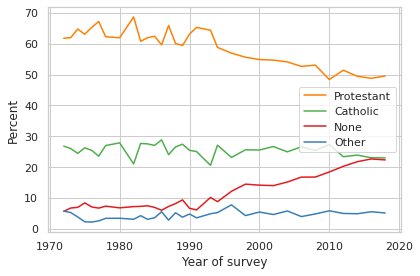

In [100]:
plot_relig(grouped_year)
decorate(xlabel='Year of survey', ylabel='Percent')

In [101]:
grouped_age = sample.groupby(['age_group'])

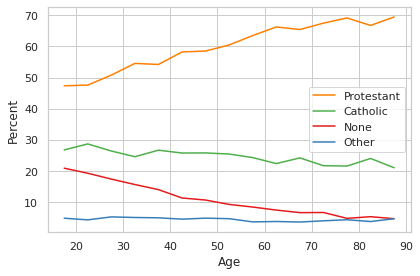

In [102]:
plot_relig(grouped_age)
decorate(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [103]:
grouped_cohort = sample.groupby(['cohort5'])
#counts = grouped_cohort.relig.count()
#counts

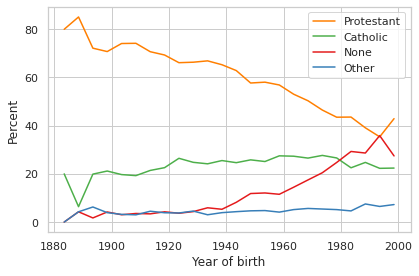

In [104]:
plot_relig(grouped_cohort)
decorate(xlabel='Year of birth', ylabel='Percent')

## Multinomial models

In [105]:
def make_multi_model(df, var, factors):
    """Fit a multinomial logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors
    
    returns: MNLogit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return MNLogit(y, X).fit(disp=False, full_output=False)

In [106]:
def predict_multi_model(age, model, year, factors, index):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: MNLogit model
    year: year to make a prediction for
    factors: list of string names for factors
    index: list of strings, index of result Series
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # simplification:
    # assume that all respondents have the mean probability for
    # each category, and sample from the multinomial distribution
    #means = pred.mean(axis=0)
    #freqs0 = np.random.multinomial(n, means) / n
    
    # non-simplification: treat each row as a predictive distribution
    # and draw a sample from each row
    
    # compute cumulative probabilities along each row
    cumpred = pred.cumsum(axis=1)
    
    # generate a random value for each row and compare to the
    # cumulative probabilities
    temp = np.random.random(n)[:,None] <= cumpred
    
    # find the index of the first True in each row
    choices = temp.argmax(axis=1) + 1
    
    # compute the PMF of the choices
    _, counts = np.unique(choices, return_counts=True)
    freqs = counts / n

    return pd.Series(freqs, index=index) * 100

In [107]:
train_year = 2018
train = sample[sample.year <= train_year]

In [108]:
factors = ['ones', 'a', 'c']
model = make_multi_model(train, 'relig4', factors)

In [109]:
age = sample.loc[sample.year==train_year, 'age']
index = ['prot', 'cath', 'other', 'none']

In [110]:
predict_multi_model(age, model, 1976, factors, index)

prot     66.424605
cath     24.818454
other     3.588210
none      5.168731
dtype: float64

In [111]:
predict_multi_model(age, model, 2016, factors, index)

prot     49.551474
cath     23.109782
other     4.613413
none     22.725331
dtype: float64

In [112]:
predict_multi_model(age, model, 2026, factors, index)

prot     41.862452
cath     21.742845
other     5.766766
none     30.627937
dtype: float64

In [113]:
predict_multi_model(age, model, 2036, factors, index)

prot     35.027766
cath     20.504058
other     5.595899
none     38.872277
dtype: float64

In [114]:
def make_multi_pred(df, var, varnames, train_year, years, factors, index):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    train_year: upper bound or (low, high) tuple for years of data
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    index: index for the resulting DataFrame
    
    returns: DataFrame that maps from index to predicted values
    """
    try:
        low, high = train_year
    except TypeError:
        low = 0
        high = train_year
        
    train = df[(df.year >= low) & (df.year <= high)]
    age = df.loc[df.year==high, 'age']
    
    model = make_multi_model(train, var, factors)
    
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

In [117]:
def plot_multi_pred(df, pred, varnames, colors, alpha=0.3):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        series.plot(color=color, alpha=alpha)
    decorate(xlabel='Year of survey')

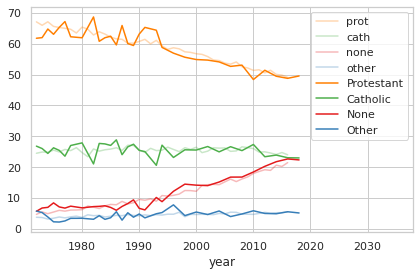

In [118]:
var = 'relig4'
varnames = ['prot', 'cath', 'none', 'other']
colors = [ORANGE, GREEN, RED, BLUE]
train_year = 2006
years = np.arange(1972, 2017)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)
decorate(xlim=[1971, 2038])

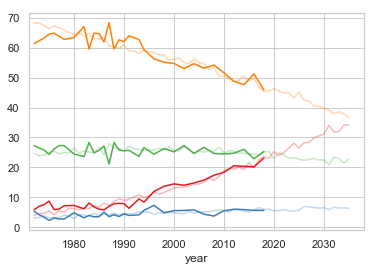

In [65]:
train_year = 2018
years = np.arange(1972, 2036)

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)

decorate(xlim=[1971, 2038])

## Belief in God

I don't believe in God.....................1 

I don't know whether there is a God and I don''t believe there is any way to find out..................................2

I don't believe in a personal God, but I do believe in a Higher Power of some kind........................3 

I find myself believing in God some of the time, but not at others........4 

While I have doubts, I feel that I do believe in God….............................5 

I know God really exists and I have no doubts about it...........................6

In [119]:
def plot_beliefs(grouped):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    varnames = ['strongbelief', 'belief', 'nobelief']
    colors = [BLUE, PURPLE, RED]
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

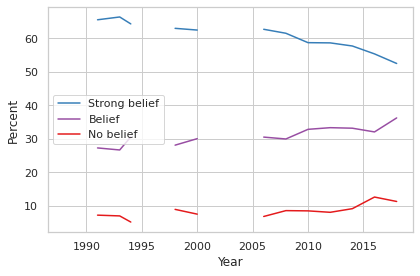

In [121]:
plot_beliefs(grouped_year)
decorate(xlabel='Year', ylabel='Percent')

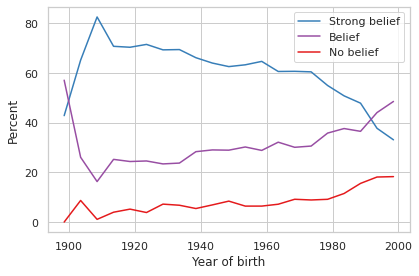

In [123]:
plot_beliefs(grouped_cohort)
decorate(xlabel='Year of birth', ylabel='Percent')

In [124]:
formula = 'belief3 ~ c + a'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.868667
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                belief3   No. Observations:                24645
Model:                        MNLogit   Df Residuals:                    24639
Method:                           MLE   Df Model:                            4
Date:                Thu, 25 Aug 2022   Pseudo R-squ.:                 0.01244
Time:                        09:42:50   Log-Likelihood:                -21408.
converged:                       True   LL-Null:                       -21678.
Covariance Type:            nonrobust   LLR p-value:                2.173e-115
==============================================================================
 belief3=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2441      0.029     42.302      0.000       1.186       1.302
c             -0.0147      0.003     -5.385      0.000      -0.020      -0.009
a             -0.0067      0.003     -2.214      0.027      -0.013      -0.001
------------------------------------------------------------------------------
 belief3=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8106      0.028     64.649      0.000       1.756       1.865
c             -0.0301      0.003    -11.556      0.000      -0.035      -0.025
a             -0.0094      0.003     -3.275      0.001      -0.015      -0.004
==============================================================================
"""

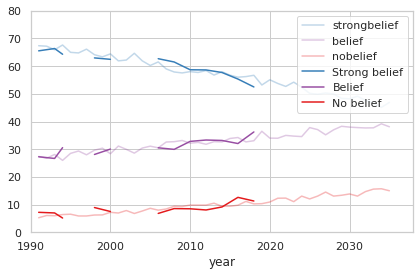

In [125]:
var = 'belief3'
varnames = ['strongbelief', 'belief', 'nobelief']
colors = [BLUE, PURPLE, RED]
train_year = 2018
years = np.arange(1991, 2036)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_beliefs(grouped_year)

decorate(xlim=[1990, 2038], ylim=[0, 80])

In [126]:
make_multi_pred(sample, var, varnames, train_year, [1996, 2016, 2036], factors, index)

,strongbelief,belief,nobelief
1996,63.263563,30.243486,6.492952
2016,56.258009,33.831696,9.910295
2036,47.671935,37.419906,14.908159


## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [127]:
def plot_conf(grouped):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    varnames = ['confident', 'someconf', 'noconf']
    colors = [BLUE, PURPLE, RED]
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

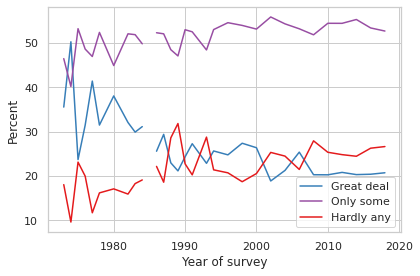

In [129]:
plot_conf(grouped_year)
decorate(xlabel='Year of survey', ylabel='Percent')

AttributeError: 'AxesSubplot' object has no property 'loc'

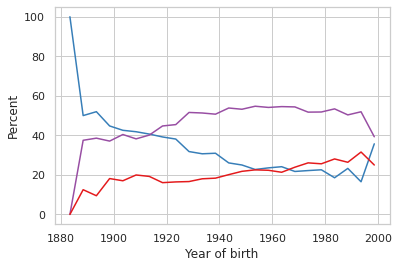

In [130]:
plot_conf(grouped_cohort)
decorate(xlabel='Year of birth', ylabel='Percent', loc='upper right')

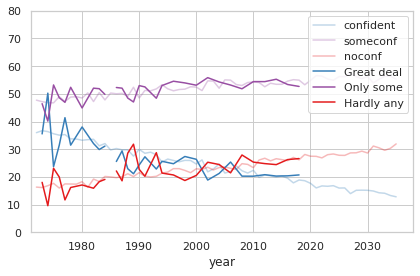

In [131]:
var = 'conclerg'
varnames = ['confident', 'someconf', 'noconf']
colors = [BLUE, PURPLE, RED]
train_year = 2018
years = np.arange(1972, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_conf(grouped_year)

decorate(xlim=[1971, 2038], ylim=[0, 80])

In [132]:
make_multi_pred(sample, var, varnames, train_year, [1976, 2016, 2036], factors, index)

,confident,someconf,noconf
1976,33.404528,49.551474,17.043998
2016,19.948740,55.019223,25.032038
2036,14.480991,54.592055,30.926954


## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [133]:
def plot_bible(grouped):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    varnames = ['literal', 'inspired', 'legends']
    colors = [BLUE, PURPLE, RED]
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

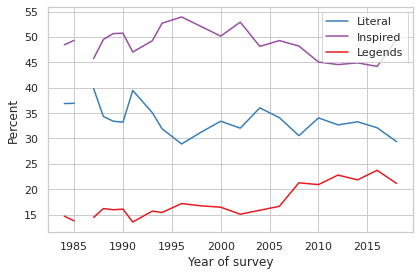

In [135]:
plot_bible(grouped_year)
decorate(xlabel='Year of survey', ylabel='Percent')

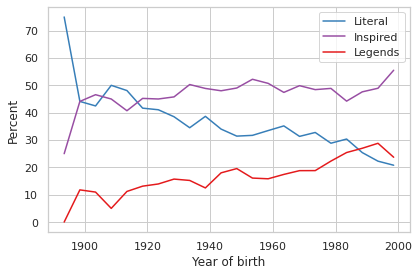

In [138]:
plot_bible(grouped_cohort)
decorate(xlabel='Year of birth', ylabel='Percent')

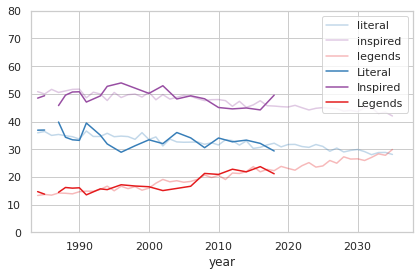

In [139]:
var = 'bible'
varnames = ['literal', 'inspired', 'legends']
colors = [BLUE, PURPLE, RED]
train_year = 2018
years = np.arange(1984, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_bible(grouped_year)

decorate(xlim=[1983, 2038], ylim=[0, 80])

In [140]:
make_multi_pred(sample, var, varnames, train_year, [1986, 2016, 2036], factors, index)

,literal,inspired,legends
1986,35.583084,50.234942,14.181974
2016,33.489962,44.126442,22.383597
2036,27.466894,44.382742,28.150363


## Resampling

In [141]:
#import age_religion
#gss = age_religion.read_gss()

In [142]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [143]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [144]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=0.2)
        if plot:
            plt.plot(xs.to_numpy(), rows[1], color=color, label=label)

In [145]:
def run_data(df, groupvar, varnames, iters=101):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [146]:
def run_model(df, var, varnames, train_year, years, index, iters=101):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    train_year: last year of data to use
    years: list of years to predict
    index: list of string variable names to extract
    iters: number of resamples
    """
    factors = ['ones', 'a', 'c']

    def run():
        sample = utils.ResampleByYear(df)
        return make_multi_pred(sample, var, varnames,
                               train_year, years, factors, index)

    dfs = [run() for _ in range(iters)]
    return dfs

## Affiliation

In [147]:
groupvar = 'year'
varnames = ['prot', 'cath', 'none', 'other']

In [148]:
dfs1 = run_data(gss, groupvar, varnames, iters=101)

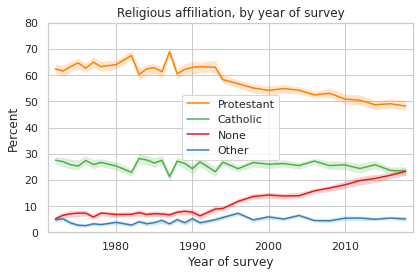

In [149]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs1, varnames, colors, labels)
decorate(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2019], ylim=[0, 80])

In [150]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=101)

Writing affiliation_cohort.png


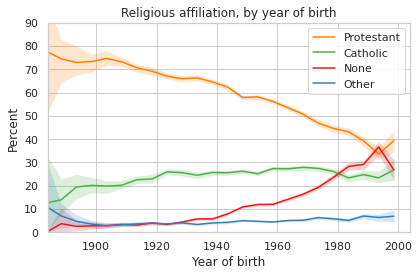

In [152]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs2, varnames, colors, labels)
decorate(title='Religious affiliation, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2004], ylim=[0, 90])

thinkplot.SaveFormat('affiliation_cohort', 'png')

Train with all data

In [153]:
var = 'relig4'
train_year = 2018
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

dfs3 = run_model(gss, var, varnames, train_year, years, index, iters=101)

Writing affiliation_year.png


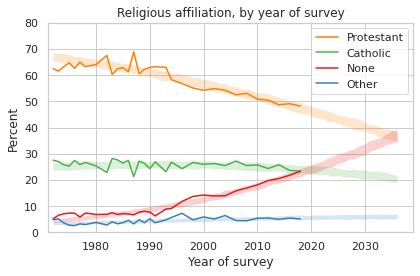

In [155]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
nolabels= [None] * 4
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

thinkplot.SaveFormat('affiliation_year', 'png')

Train with data since 1990

In [156]:
var = 'relig4'
train_year = 1990, 2018
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

dfs3a = run_model(gss, var, varnames, train_year, years, index, iters=101)

Writing affiliation_year_1996.png


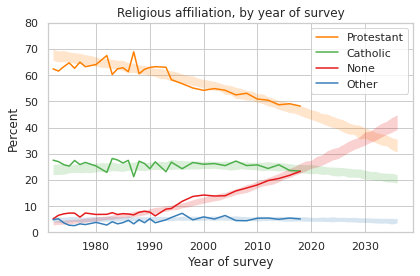

In [157]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
nolabels= [None] * 4
plot_percentiles(dfs3a, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

thinkplot.SaveFormat('affiliation_year_1996', 'png')

Train with data up to 2006

In [158]:
var = 'relig4'
train_year = 2006
factors = ['ones', 'a', 'c']

dfs4 = run_model(gss, var, varnames, train_year, years, index, iters=101)

Writing affiliation_year_2006.png


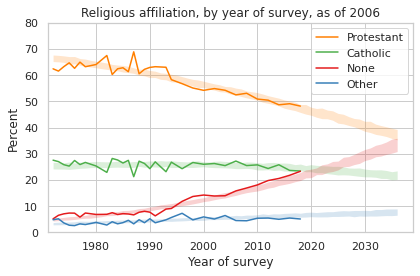

In [159]:
plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(title='Religious affiliation, by year of survey, as of 2006', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

thinkplot.SaveFormat('affiliation_year_2006', 'png')

Train with data up to 1996

In [160]:
train_year = 1996

dfs4a = run_model(gss, var, varnames, train_year, years, index, iters=101)

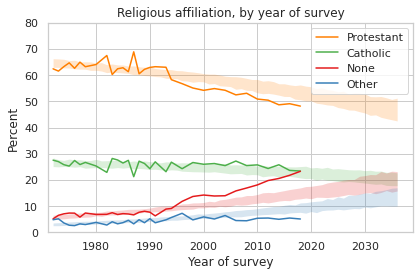

In [161]:
plot_percentiles(dfs4a, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

In [162]:
ps = np.array([0.5])
series_seq = [df['other'] for df in dfs3]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016]]

,0
1976,3.716361
1986,4.058095
1996,4.741563
2006,5.126015
2016,5.553182


## Beliefs

In [163]:
groupvar = 'year'
varnames = ['strongbelief', 'belief', 'nobelief']

In [164]:
dfs5 = run_data(gss, groupvar, varnames, iters=101)

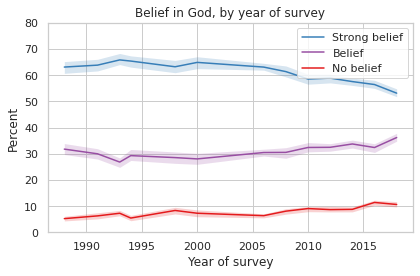

In [165]:
colors = [BLUE, PURPLE, RED]
labels = ['Strong belief', 'Belief', 'No belief']

plot_percentiles(dfs5, varnames, colors, labels)
decorate(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 ylim=[0, 80])

In [166]:
groupvar = 'cohort5'
dfs6 = run_data(gss, groupvar, varnames, iters=101)

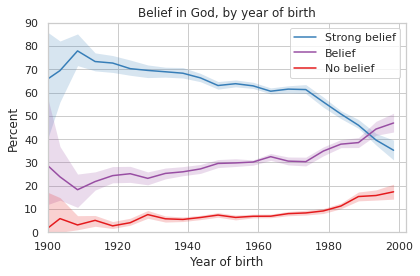

In [167]:
plot_percentiles(dfs6, varnames, colors, labels)
decorate(title='Belief in God, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1900, 2002], ylim=[0, 90])

In [168]:
var = 'belief3'
train_year = 2018
years = np.arange(1988, 2037)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

In [169]:
dfs7 = run_model(gss, var, varnames, train_year, years, index, iters=101)

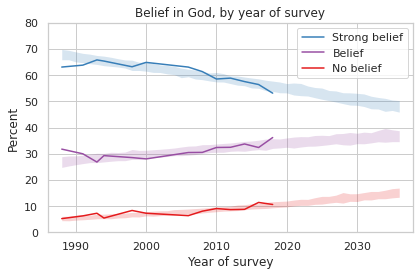

In [170]:
plot_percentiles(dfs7, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs5, varnames, colors, labels, fill=False)
decorate(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1986, 2038], ylim=[0, 80])

In [171]:
var = 'nobelief'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs7]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1996, 2006, 2016, 2026, 2036]]

,0
1996,6.279368
2006,8.116190
2016,9.953012
2026,12.345152
2036,15.249893


## Confidence

In [172]:
groupvar = 'year'
varnames = ['confident', 'someconf', 'noconf']

In [173]:
dfs8 = run_data(gss, groupvar, varnames, iters=101)

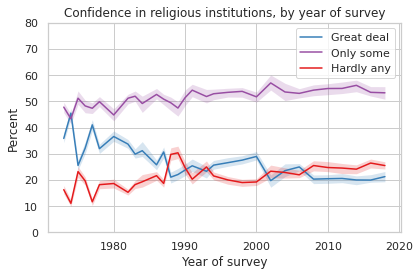

In [174]:
colors = [BLUE, PURPLE, RED]
labels = ['Great deal', 'Only some', 'Hardly any']

plot_percentiles(dfs8, varnames, colors, labels)
decorate(title='Confidence in religious institutions, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent', ylim=[0, 80])

In [175]:
groupvar = 'cohort5'
dfs9 = run_data(gss, groupvar, varnames, iters=101)

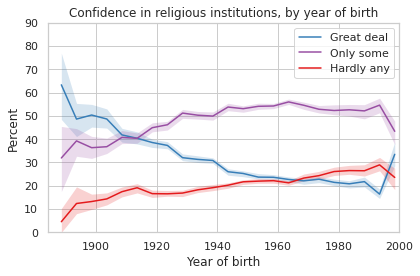

In [176]:
plot_percentiles(dfs9, varnames, colors, labels)
decorate(title='Confidence in religious institutions, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1884, 2000], ylim=[0, 90])

In [177]:
var = 'conclerg'
train_year = 2018
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['confident', 'someconf', 'noconf']

In [178]:
dfs10 = run_model(gss, var, varnames, train_year, years, index, iters=101)

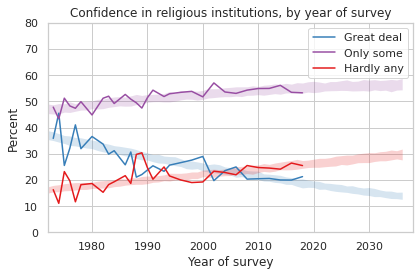

In [179]:
plot_percentiles(dfs10, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs8, varnames, colors, labels, fill=False)
decorate(title='Confidence in religious institutions, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2038], ylim=[0, 80])

In [180]:
var = 'noconf'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs10]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,17.172149
1986,19.222554
1996,21.102093
2006,23.451516
2016,25.758223
2026,27.466894
2036,29.688167


## Bible

In [181]:
groupvar = 'year'
varnames = ['inspired', 'literal', 'legends']

In [182]:
dfs11 = run_data(gss, groupvar, varnames, iters=101)

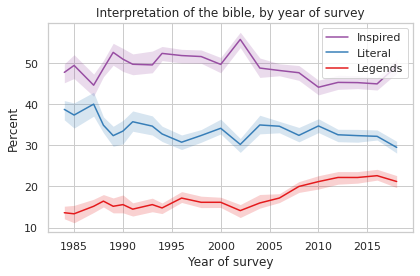

In [183]:
colors = [PURPLE, BLUE, RED]
labels = ['Inspired', 'Literal', 'Legends']

plot_percentiles(dfs11, varnames, colors, labels)
decorate(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

In [184]:
groupvar = 'cohort5'
dfs12 = run_data(gss, groupvar, varnames, iters=101)

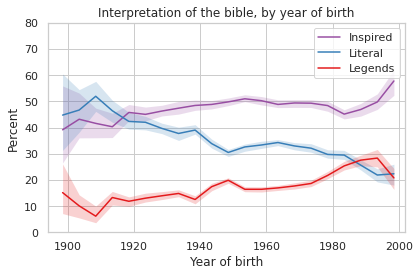

In [185]:
plot_percentiles(dfs12, varnames, colors, labels)
decorate(title='Interpretation of the bible, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1894, 2002], ylim=[0, 80])

In [186]:
var = 'bible'
train_year = 2018
years = np.arange(1984, 2037)
factors = ['ones', 'a', 'c']
index = ['literal', 'inspired', 'legends']

In [187]:
dfs13 = run_model(gss, var, varnames, train_year, years, index, iters=101)

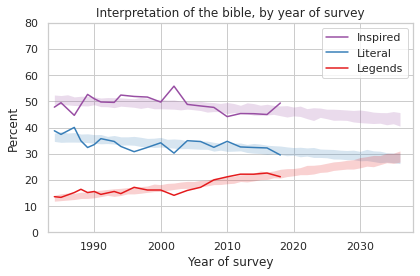

In [188]:
plot_percentiles(dfs13, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs11, varnames, colors, labels, fill=False)
decorate(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1983, 2038], ylim=[0, 80])

In [189]:
var = 'legends'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs13]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1986, 1996, 2006, 2016, 2026, 2036]]

,0
1986,13.754806
1996,15.976079
2006,18.667236
2016,21.742845
2026,25.074754
2036,28.662965
